In [1]:
import sys
sys.path.append('/NDDepth/Estimation/nddepth_custom')

In [2]:
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
from networks.NewCRFDepth import NewCRFDepth
from utils import post_process_depth, flip_lr, compute_errors

IMG_PATH = "/scratchdata/nyu_data/data/nyu2_test/00008_colors.png"
MODEL_PATH = "/scratchdata/nyu.pth"

ENCODER = "large07"
MAX_DEPTH = 10
EPOCH = 5

torch.manual_seed(42)

/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


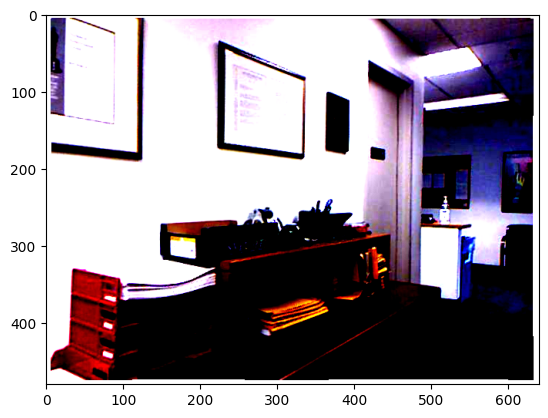

In [3]:
image = np.asarray(Image.open(IMG_PATH), dtype=np.float32) / 255.0

image = torch.from_numpy(image.transpose((2, 0, 1)))
image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)


plt.imshow(image.permute(1, 2, 0))

In [4]:
K = np.array([[518.8579 / 4.0, 0, 325.5824 / 4.0, 0],
            [0, 518.8579 / 4.0, 253.7362 / 4.0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]], dtype=np.float32) 
inv_K = np.linalg.pinv(K)
inv_K = torch.from_numpy(inv_K)

In [5]:
model = NewCRFDepth(version=ENCODER, inv_depth=False, max_depth=MAX_DEPTH, pretrained=None).to("cuda")
model.train()
num_params = sum([np.prod(p.size()) for p in model.parameters()])
print("== Total number of parameters: {}".format(num_params))

num_params_update = sum([np.prod(p.shape) for p in model.parameters() if p.requires_grad])
print("== Total number of learning parameters: {}".format(num_params_update))

model = torch.nn.DataParallel(model)
model.cuda()

print("== Model Initialized")
cudnn.benchmark = True


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


== Total number of parameters: 348400139
== Total number of learning parameters: 348400139
== Model Initialized


In [6]:
model.eval()
with torch.no_grad():
    image_torch = torch.Tensor(image.unsqueeze(0).cuda())
    inv_K_torch = torch.Tensor(inv_K.unsqueeze(0).cuda())

    depth1_list, uncer1_list, depth2_list, uncer2_list, normals, distances = model(image_torch, inv_K_torch, EPOCH)
    
    pred_depth = 0.5 * (depth1_list[-1] + depth2_list[-1])
    
    image_flipped = flip_lr(image_torch)
    depth1_list_flipped, uncer1_list_flipped, depth2_list_flipped, uncer2_list_flipped, normals_flipped, distances_flipped = model(image_flipped, inv_K_torch, EPOCH)
    pred_depth_flipped = 0.5 * (depth1_list_flipped[-1] + depth2_list_flipped[-1])
    pred_depth = post_process_depth(pred_depth, pred_depth_flipped)
    normals = (0.5 * (normals + 1)).permute(0, 2, 3, 1)

    pred_depth = pred_depth.cpu().numpy().squeeze()
    pred_normal = normals.cpu().numpy().squeeze()

torch.Size([1, 192, 120, 160])
torch.Size([1, 512, 15, 20])


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
print(pred_depth)

[[3.545588  3.545588  3.531931  ... 3.732606  3.605403  3.605403 ]
 [3.545588  3.545588  3.531931  ... 3.732606  3.605403  3.605403 ]
 [3.6761255 3.6761255 3.666257  ... 3.9203343 3.8313994 3.8313994]
 ...
 [4.170816  4.170816  4.389451  ... 4.845422  4.521763  4.521763 ]
 [4.25857   4.25857   4.4689283 ... 4.854948  4.531654  4.531654 ]
 [4.25857   4.25857   4.4689283 ... 4.854948  4.531654  4.531654 ]]


9.09143


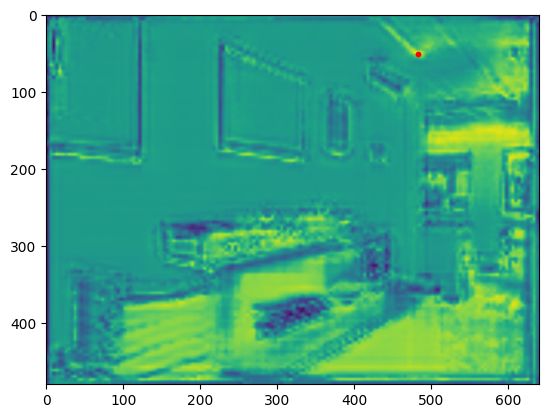

In [ ]:
pred_depth = np.reshape(pred_depth, (480, 640))
print(pred_depth.max())
pred_depth = pred_depth / pred_depth.max()
#Find index of max pred_depth
max_index = np.where(pred_depth == pred_depth.max())

plt.imshow(pred_depth)
plt.scatter(max_index[1], max_index[0], c='r', s=10)